In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from detect_staircases import classify_staircase 
plt.rcParams.update({'font.size': 16})

# Thermohaline classifier demo

This notebook demonstrates the functionality of the staircase classification algorithm

### Test classifier with synthetic data

First we create synthetic profiles of temperature and salinity data to check that the classifier works on idealised data. This is similar to the [internal software test](https://github.com/callumrollo/thermohaline-steps/blob/main/test_staircase.py) used in development

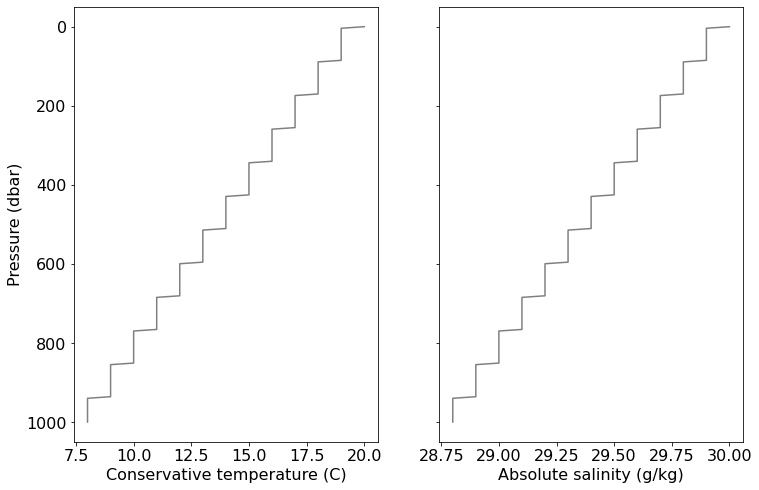

In [2]:
p_in = np.arange(1000)
ct_in = np.empty(len(p_in))
sa_in = np.empty(len(p_in))

diff_c = -1
diff_s = -0.1
mix = 80
interface = 5
current_c = 20
current_s = 30
for start in np.arange(0, 1000, mix+interface):
    ct_in[start: start + interface] = np.linspace(current_c, current_c + diff_c, interface)
    current_c +=diff_c
    ct_in[start + interface: start + interface + mix] = current_c
    sa_in[start: start + interface] = np.linspace(current_s, current_s + diff_s, interface)
    current_s +=diff_s
    sa_in[start + interface: start + interface + mix] = current_s  

fig, ax = plt.subplots(1,2, figsize=(12,8), sharey="row")
ax = ax.ravel()
ax[0].plot(ct_in, p_in, color="k", alpha=0.5)
ax[0].set(xlabel="Conservative temperature (C)", ylabel="Pressure (dbar)")
ax[1].plot(sa_in, p_in, color="k", alpha=0.5)
ax[1].set(xlabel="Absolute salinity (g/kg)")
ax[0].invert_yaxis()

df, mixes, grads = classify_staircase(p_in, ct_in, sa_in)

Next we run the classifier on this synthetic data and plot the results

In [3]:
df, mixes, grads = classify_staircase(p_in, ct_in, sa_in)

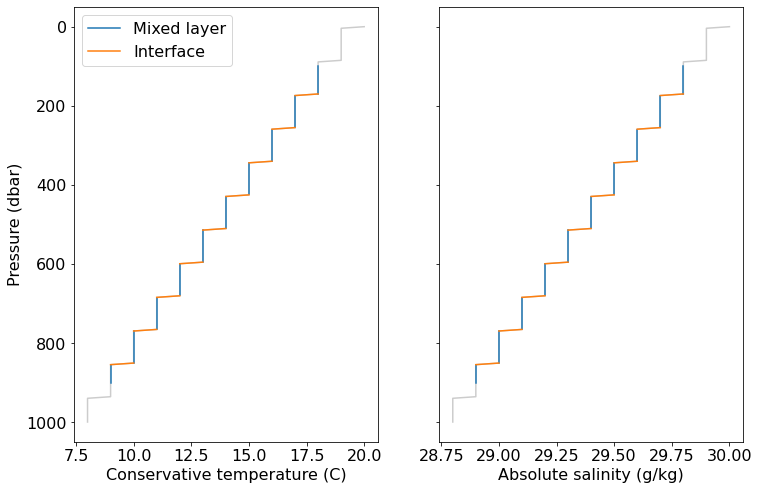

In [4]:
fig, ax = plt.subplots(1,2, figsize=(12,8), sharey="row")
ax = ax.ravel()
ax[0].plot(ct_in, p_in, color="k", alpha=0.2)
ax[0].set(xlabel="Conservative temperature (C)", ylabel="Pressure (dbar)")
ax[1].plot(sa_in, p_in, color="k", alpha=0.2)
ax[1].set(xlabel="Absolute salinity (g/kg)")

ax[0].plot(np.ma.array(df.ct, mask=df['mixed_layer_final_mask']), df.p, color='C0', label="Mixed layer")
ax[0].plot(np.ma.array(df.ct, mask=df['gradient_layer_final_mask']), df.p, color='C1', label="Interface")
ax[1].plot(np.ma.array(df.sa, mask=df['mixed_layer_final_mask']), df.p, color='C0')
ax[1].plot(np.ma.array(df.sa, mask=df['gradient_layer_final_mask']), df.p, color='C1')

ax[0].legend()
ax[0].invert_yaxis()

Due to the use of a rolling mean window to calculate background gradients, the upper and lower ends of the profile are not classified

### Experimentation

We can turn the above process into a function and re-run it with different input data

In [5]:
def classify_test_data(p, ct, sa, temp_flag_only=False):
    df, mixes, grads = classify_staircase(p, ct, sa, temp_flag_only=temp_flag_only)
    fig, ax = plt.subplots(1,2, figsize=(12,8), sharey="row")
    ax = ax.ravel()
    ax[0].plot(ct, p, color="k", alpha=0.2)
    ax[0].set(xlabel="Conservative temperature (C)", ylabel="Pressure (dbar)")
    ax[1].plot(sa, p, color="k", alpha=0.2)
    ax[1].set(xlabel="Absolute salinity (g/kg)")

    ax[0].plot(np.ma.array(df.ct, mask=df['mixed_layer_final_mask']), df.p, color='C0', label="Mixed layer")
    ax[0].plot(np.ma.array(df.ct, mask=df['gradient_layer_final_mask']), df.p, color='C1', label="Interface")
    ax[1].plot(np.ma.array(df.sa, mask=df['mixed_layer_final_mask']), df.p, color='C0')
    ax[1].plot(np.ma.array(df.sa, mask=df['gradient_layer_final_mask']), df.p, color='C1')

    ax[0].legend()
    ax[0].invert_yaxis()

Let's try adding some random noise to the input data salinity

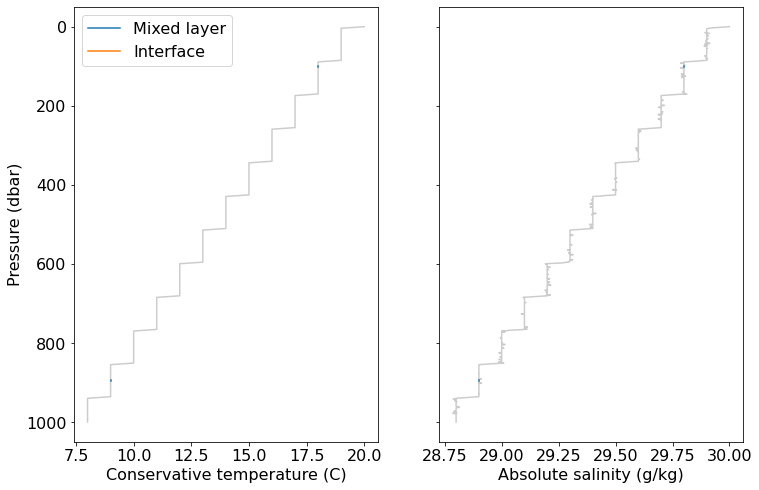

In [16]:
arr_len = len(p_in)
rand_sample_a = (np.random.random(arr_len) - 0.5) * np.random.randint(2, size=arr_len) * np.random.randint(2, size=arr_len)  * np.random.randint(2, size=arr_len) 
sa_noise = sa_in + 0.03 * rand_sample_a
classify_test_data(p_in, ct_in, sa_noise)

Using default setttins, noisy salinity prevents the identification of salinity data. For this reason, we use the `temp_flag_only` kwarg to perform the preliminary classification with temperature only

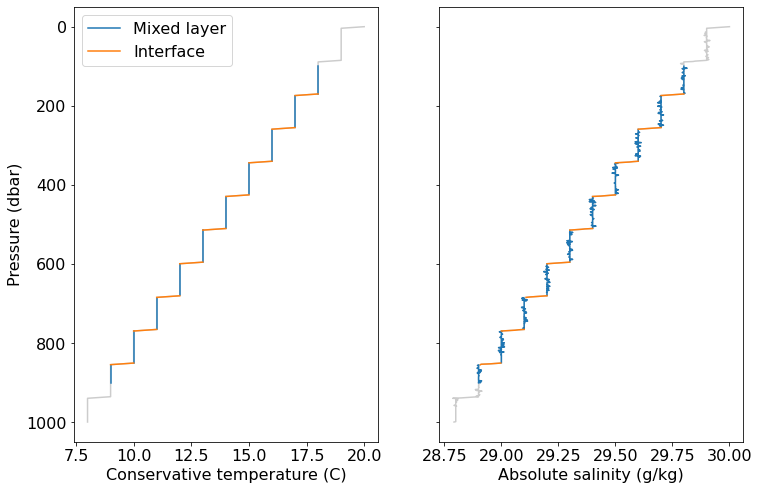

In [7]:
classify_test_data(p_in, ct_in, sa_noise, temp_flag_only=True)

As well as producing masks of final mixed layers and interfaces, the classifier returns the results of the classification steps and statistics on the mixed layers and interfaces

In [8]:
df.head()

,p,ct,sa,sigma1,alpha_smooth,beta_smooth,turner_ang,density_ratio,mixed_layer_final_mask,mixed_layer_temp_mask,...,mixed_layer_mask,gradient_layer_final_mask,mixed_layer_step1_mask,grad_layer_step2_mask,grad_layer_step3_mask,grad_layer_step4_mask,mixed_layer_salt_finger_mask,gradient_layer_salt_finger_mask,mixed_layer_diffusive_convective_mask,gradient_layer_diffusive_convective_mask
1,1,19.75,29.975,25.244920,NaN,NaN,NaN,NaN,True,True,...,True,True,True,True,True,True,True,True,True,True
2,2,19.50,29.950,25.292681,NaN,NaN,NaN,NaN,True,True,...,True,True,True,True,True,True,True,True,True,True
3,3,19.25,29.925,25.339905,NaN,NaN,NaN,NaN,True,True,...,True,True,True,True,True,True,True,True,True,True
4,4,19.00,29.900,25.386590,NaN,NaN,NaN,NaN,True,True,...,True,True,True,True,True,True,True,True,True,True
5,5,19.00,29.900,25.386590,NaN,NaN,NaN,NaN,True,True,...,True,True,True,True,True,True,True,True,True,True


In [9]:
mixes

,p_start,p_end,ct,sa,sigma1,p,ct_range,sa_range,sigma1_range,layer_height,turner_ang,density_ratio,salt_finger_step,diffusive_convection_step,diffusive_convection,bad_mixed_layer
0,100.0,169.0,18.0,29.8,25.567890,134.5,0.0,0.0,0.0,69.0,43.278137,2.447287,True,False,True,False
1,175.0,254.0,17.0,29.7,25.740367,214.5,0.0,0.0,0.0,79.0,38.721540,3.038346,True,False,NaN,False
2,260.0,339.0,16.0,29.6,25.903856,299.5,0.0,0.0,0.0,79.0,39.109213,2.929007,True,False,NaN,False
3,345.0,424.0,15.0,29.5,26.058186,384.5,0.0,0.0,0.0,79.0,41.776621,2.606176,True,False,NaN,False
4,430.0,509.0,14.0,29.4,26.203182,469.5,0.0,0.0,0.0,79.0,39.977256,2.708077,True,False,NaN,False
5,515.0,594.0,13.0,29.3,26.338656,554.5,0.0,0.0,0.0,79.0,41.590183,2.494612,True,False,NaN,False
6,600.0,679.0,12.0,29.2,26.464417,639.5,0.0,0.0,0.0,79.0,59.557648,1.521423,True,False,NaN,False
7,685.0,764.0,11.0,29.1,26.580262,724.5,0.0,0.0,0.0,79.0,41.572729,2.370605,True,False,NaN,False
8,770.0,849.0,10.0,29.0,26.685977,809.5,0.0,0.0,0.0,79.0,44.454507,2.086042,True,False,NaN,False
9,855.0,900.0,9.0,28.9,26.781339,877.5,0.0,0.0,0.0,45.0,39.907037,2.001343,True,False,True,False


In [10]:
grads

,p_start,p_end,ct,sa,sigma1,p,ct_range,sa_range,sigma1_range,layer_height,turner_ang,density_ratio,bad_grad_layer,adj_ml_height,height_ratio,salt_finger,diffusive_convection,salt_finger_step,diffusive_convection_step
0,170.0,174.0,17.5,29.75,25.654685,172.0,1.0,0.1,0.172477,4.0,62.916891,3.092945,False,79.0,19.75,True,False,True,False
1,255.0,259.0,16.5,29.65,25.822678,257.0,1.0,0.1,0.163489,4.0,63.527239,2.983973,False,79.0,19.75,True,False,True,False
2,340.0,344.0,15.5,29.55,25.981599,342.0,1.0,0.1,0.154331,4.0,64.183553,2.874269,False,79.0,19.75,True,False,True,False
3,425.0,429.0,14.5,29.45,26.131273,427.0,1.0,0.1,0.144995,4.0,64.891124,2.763811,False,79.0,19.75,True,False,True,False
4,510.0,514.0,13.5,29.35,26.271520,512.0,1.0,0.1,0.135475,4.0,65.656094,2.652573,False,79.0,19.75,True,False,True,False
5,595.0,599.0,12.5,29.25,26.402150,597.0,1.0,0.1,0.125761,4.0,66.485622,2.540521,False,79.0,19.75,True,False,True,False
6,680.0,684.0,11.5,29.15,26.522966,682.0,1.0,0.1,0.115844,4.0,67.388095,2.427618,False,79.0,19.75,True,False,True,False
7,765.0,769.0,10.5,29.05,26.633759,767.0,1.0,0.1,0.105715,4.0,68.373384,2.313817,False,79.0,19.75,True,False,True,False
8,850.0,854.0,9.5,28.95,26.734313,852.0,1.0,0.1,0.095362,4.0,69.453168,2.199066,False,79.0,19.75,True,False,True,False


# Classifier on Argo data

Here we use Argo data from the Meditteranean to test the classifier against a real world example.

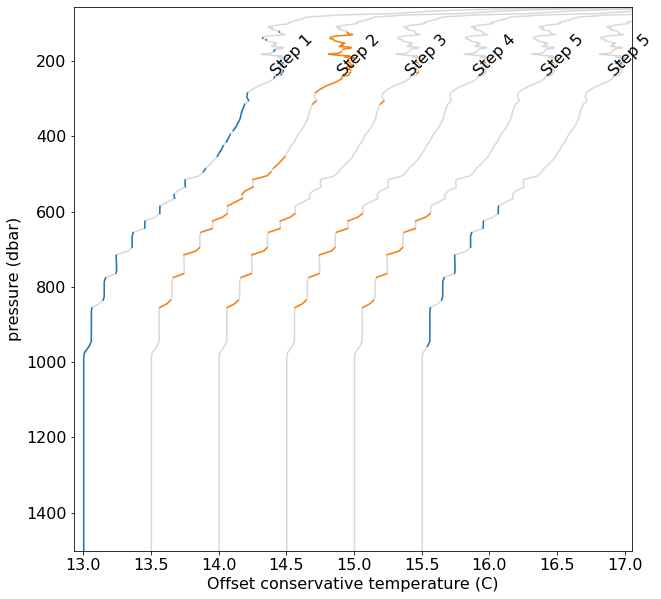

In [23]:
df_in = pd.read_csv('data/vanderboog_argo_demo_data.csv')
df_out, mixes, grads = classify_staircase(df_in.pressure, df_in.conservative_temperature, df_in.absolute_salinity,
                                          temp_flag_only=True, show_steps=True)

In [ ]:
df_out, mixes, grads = classify_staircase(df_in.pressure, df_in.conservative_temperature, df_in.absolute_salinity,
                                          temp_flag_only=True, show_steps=True, layer_height_ratio=0.95, ml_grad=0.00048)

### Help on the classifier

By calling `help()` on the classifier, we can view the docstring and see definitions of the variables that must be passed to it, and what the classifier kwargs are

In [12]:
help(classify_staircase)

Help on function classify_staircase in module detect_staircases:

classify_staircase(p, ct, sa, ml_grad=0.0005, ml_density_difference=0.005, av_window=200, interface_max_height=30, layer_height_ratio=1, temp_flag_only=False, show_steps=False)
    all data should be at 1 dbar resolution (for now)
    Notes:
    - Currently dropping min and max pressure values, so can have Turner angle at all points
    - Turner angle and stability-ratio from smoothed profile
    :param show_steps: if True, creates and shows a plot of filtering steps, default: False
    :param p: pressure (dbar)
    :param ct: conservative temperature (degrees celsius)
    :param sa: absolute salinity (g kg-1)
    :param ml_grad: density gradient for detection of mixed layer (kg m^-3 dbar^-1), default: 0.0005
    :param ml_density_difference: maximum density gradient difference of mixed layer (kg m^-3), default: 0.005
    :param av_window: averaging window to obtain background profiles (dbar), default: 200
    :param int